In [1]:
%matplotlib notebook

from IPython.display import clear_output

from NIX_Testing import NIX_Image_List, NIX_Image, doGridAnalysis, ProgressBar
from pylab import *
from astropy.io import fits
from lmfit.models import PolynomialModel
import pickle
import multiprocessing as mp

data_dir = '/home/ydallilar/Documents/NIX/nixDetBackup'

test_ids = ['PER-124-04-1']
config = {'test_ids' : test_ids, 'data_dir' : data_dir}
NIX_GL = NIX_Image_List(config)

In [2]:
def mlinregress(data1, data2, extend=10, cpu=6):
    pb = ProgressBar()
    angs = zeros([2048, 2048])
    lins = zeros([2048, 2048])
    Rs = zeros([2048, 2048])
    pool = mp.Pool(cpu)
    for i in range(2048):
        arr1s = [data1[i,j,:extend] for j in range(2048)]
        arr2s = [data2[i,j,:extend] for j in range(2048)]
        out = pool.map(do_linregress, zip(arr1s, arr2s))
        for j in range(2048):
            angs[i,j], lins[i,j], Rs[i,j] = out[j][0], out[j][1], out[j][2]
            
        pb.report(i+1, 2048)
    return angs, lins, Rs
    
def do_linregress(args):
    arr1, arr2 = args
    ang, lin, R, _, _ = linregress(arr1, arr2)
    return ang, lin, R


In [3]:
sz = len(NIX_GL)/2

ref = zeros([2048, 2048, sz/2])
ims = zeros([2048, 2048, sz/2])
exps = zeros([2048, 2048, sz/2])

for i in range(sz/2):
    ims[:,:,i] = NIX_GL[2*i+40].getImage(dark=NIX_GL[2*i])
    ref[:,:,i] = ims[:,:,0]*(2+2*i)
    exps[:,:,i] = 2+2*i

(180, 160) (181,) (21,)


<IPython.core.display.Javascript object>


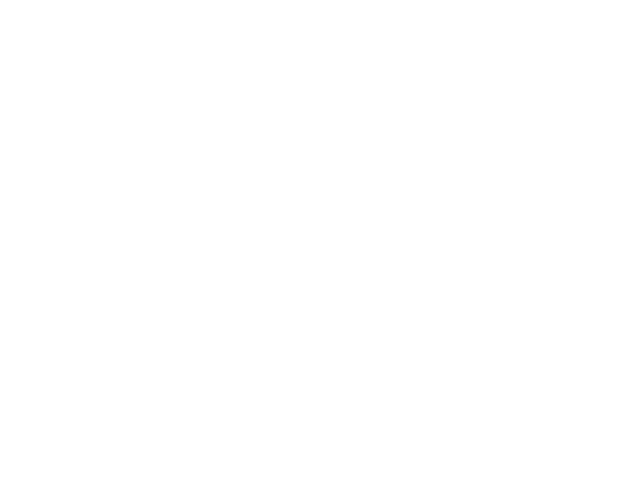

2098945.0


In [4]:
hist, binsx, binsy = histogram2d(ravel(ims), ravel(exps), 
                                 bins=[arange(0, 18001, 100), arange(1, 42, 2)])

hist = repeat(hist, 8, axis=1)
print hist.shape, binsx.shape, binsy.shape
#contour(binsy[1:], binsx[1:], hist)
#print hist
imshow(hist)
gca().invert_yaxis()
show()
print amax(hist)


In [5]:
from scipy.stats import linregress
lins = zeros([2048, 2048])
angs = zeros([2048, 2048])
rs = zeros([2048, 2048])

angs, lins, rs = mlinregress(exps, ims,cpu=6)

#for i in range(2048):
#    progressbar(i, 2048)
#    for j in range(2048):
#        angs[i,j], lins[i,j], rs[i,j], _, _ = linregress(exps[i,j,:10], ims[i,j,:10])

[####################] 100% 02:13/02:13


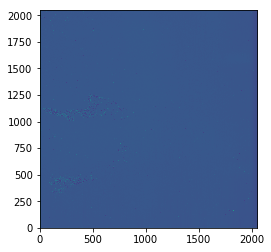

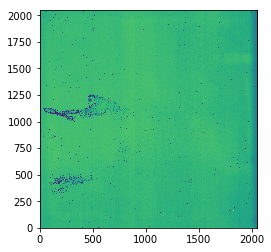

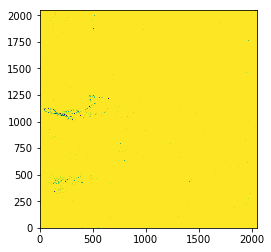

In [6]:
%matplotlib inline
figure()
imshow(lins)
gca().invert_yaxis()
fits.PrimaryHDU(lins).writeto("out/reg_lins.fits", overwrite=True)
figure()
imshow(angs)
gca().invert_yaxis()
fits.PrimaryHDU(angs).writeto("out/reg_angs.fits", overwrite=True)
figure()
imshow(rs**2)
gca().invert_yaxis()
fits.PrimaryHDU(rs**2).writeto("out/reg_R2.fits", overwrite=True)

NPhot = (ims[:,:,10]-lins)/angs

fits.PrimaryHDU(NPhot).writeto("out/reg_NPhot.fits", overwrite=True)
fits.PrimaryHDU(ims[:,:,10]).writeto("out/reg_Orig.fits", overwrite=True)
fits.PrimaryHDU(ims[:,:,10]/NPhot).writeto("out/reg_test.fits", overwrite=True)